<a href="https://colab.research.google.com/github/Arye182/Deep_Learning_Monet_Competition_Kaggle/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
The project is a part of a final assignment in course deep learning, as part of kaggle competition im I’m Something of a Painter Myself in which we can actually take photos from life and translate them into monet styled photos. Adding style to photos is a very popular issue in programming nowadays, we see a lot of filters and image processing applications on a daily basis. The ability to take photos and mimic the style of an artist is a quite impressive challenge.     

  
**References**  
  
    
      

https://www.kaggle.com/amyjang/monet-cyclegan-tutorial - tuturial notebook  
https://www.kaggle.com/unfriendlyai/cyclegan-with-dg-pretraining - used the help to create fid
https://www.tensorflow.org/tutorials/images/data_augmentation - augmentation




# Installations & Imports & Functions & Parameters
here we will prepare everything

#### Installations

In [1]:
!pip install -q kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install tensorflow_addons
!pip install image-quality

     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=0cc79512d2b5edd5e5d28cb54b3016bab0eb86df9d29f239eb770a4a81afa477
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 679 kB 5.3 MB/s 
     |████████████████████████████████| 146 kB 5.3 MB/s 
     |████████████████████████████████| 170 kB 54.5 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233373 sha256=98e9333e42f0412256e69bcbfb2c7bcb4dcf7695811db91baee4f5345ba76817
  Stored in directory: /root/.cache/pip/wheels/cd/e8/1e/bf95cf256e4d3ffc94289ab508c49d48e34c98220af63e3513
Successfully built libsvm


#### Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from google.colab import files
import PIL
import shutil
from tensorflow.keras.callbacks import History
import imquality.brisque as brisque
import PIL.Image

import os, random, json, PIL, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras import Model, losses, optimizers
import time
import zipfile
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [40]:
from google.colab import auth
auth.authenticate_user()
!curl https://sdk.cloud.google.com | bash
!gcloud init

Streaming output truncated to the last 5000 lines.
google-cloud-sdk/lib/surface/projects/remove_iam_policy_binding.yaml
google-cloud-sdk/lib/surface/projects/set_iam_policy.py
google-cloud-sdk/lib/surface/projects/set_iam_policy.yaml
google-cloud-sdk/lib/surface/projects/undelete.py
google-cloud-sdk/lib/surface/projects/update.py
google-cloud-sdk/lib/surface/publicca/__init__.py
google-cloud-sdk/lib/surface/publicca/external_account_keys/__init__.py
google-cloud-sdk/lib/surface/publicca/external_account_keys/create.py
google-cloud-sdk/lib/surface/pubsub/__init__.py
google-cloud-sdk/lib/surface/pubsub/lite_operations/__init__.py
google-cloud-sdk/lib/surface/pubsub/lite_operations/describe.yaml
google-cloud-sdk/lib/surface/pubsub/lite_operations/list.yaml
google-cloud-sdk/lib/surface/pubsub/lite_subscriptions/__init__.py
google-cloud-sdk/lib/surface/pubsub/lite_subscriptions/ack_up_to.yaml
google-cloud-sdk/lib/surface/pubsub/lite_subscriptions/create.yaml
google-cloud-sdk/lib/surface/pub

#### Parameters

In [3]:
IMAGE_SIZE = [256, 256]
CHANNELS = 3
WIDTH = 256
HEIGHT = 256
EPOCHS = 25
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128

#### Define Auxiliry Functions

In [4]:
# Decoding an Image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# Readin Tfrec file
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

# Load A DataSet
def load_dataset(filenames, labeled=True, ordered=False):
  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
  return dataset


# Loss Graph UtilityFunctions
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_smoothed_acc_and_loss(epochs, history, factor=0.8):
    monet_g = []
    photo_g = []
    monet_d = []
    photo_d = []
    for i in range(np.array(history.history["monet_gen_loss"]).shape[0]):
        monet_g.append(history.history["monet_gen_loss"][i].squeeze().mean())
        photo_g.append(history.history["photo_gen_loss"][i].squeeze().mean())
        monet_d.append(history.history["monet_disc_loss"][i].squeeze().mean())
        photo_d.append(history.history["photo_disc_loss"][i].squeeze().mean())
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(smooth_curve(monet_g, factor=factor),label="Monet")
    axs[0].plot(smooth_curve(photo_g, factor=factor),label="Photo")
    axs[0].set_title("Smoothed generator loss")
    axs[0].legend()
    axs[1].plot(smooth_curve(monet_d, factor=factor),label="Monet")
    axs[1].plot(smooth_curve(photo_d, factor=factor),label="Photo")
    axs[1].set_title("Smoothed discriminator loss")
    axs[1].legend()
    plt.show()


# Converting Images Dir To TFREC Functions
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def get_zip_filenames(filename):
    dirname = os.path.splitext(filename)[0]
    try:
      !rm -r dirname
    except:
      print(f'can\'t delete {dirname}')
    !unzip {filename} -d {dirname}

    monet_images_filenames = []
    for file in os.scandir(dirname):
      if file.name.endswith('.jpg'):
        monet_images_filenames.append(f'{dirname}/{file.name}')
    return monet_images_filenames

# Create a dictionary with features that may be relevant.
def image_encode(image, image_name):
  tfrecord_format = {
        'image_name': _bytes_feature(image),
        'image': _bytes_feature(image),
        'target':     _bytes_feature(image)
  }
  return tf.train.Example(features=tf.train.Features(feature=tfrecord_format))

def convert_to_tfrec(images, record_file):
    with tf.io.TFRecordWriter(record_file) as writer:
      for image_path in images:
        image = open(image_path, 'rb').read()
        tf_example = image_encode(image, image_path)
        writer.write(tf_example.SerializeToString())


def display_samples(ds, row, col):
    ds_iter = iter(ds)
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        example_sample = next(ds_iter)
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
    plt.show()


#### TPU Initialization

In [41]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.122.204.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.204.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.122.204.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of replicas: 8
2.5.0


SyntaxError: ignored

# Data Base

#### Data Path And Filenames Preperations

In [42]:
GCS_PATH = 'gs://kds-fe07dc19ed486a7fdc7d0a06e0362b4db01fa035a6c107442b99a8f2'

In [45]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))



# Download the file from a given Google Cloud Storage bucket.
!gsutil cp gs://kaggle-monet/monet.tfrec /content/monet.tfrec
  
# Print the result to make sure the transfer worked.
!cat /content/monet.tfrec


COSHEN_MONET_DS_FILENAMES = tf.io.gfile.glob(str('/content/monet.tfrec'))

chosen_ds = load_dataset(COSHEN_MONET_DS_FILENAMES, labeled=True).batch(1)



Monet TFRecord Files: 5
Photo TFRecord Files: 20
Copying gs://kaggle-monet/monet.tfrec...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      
C�      ��X
��
�f
image�f
�f
�f���� JFIF      �� C 		
2!!22222222222222222222222222222222222222222222222222��   " ��           	
�� �   } !1AQa"q2���#B��R��$3br�	
%&'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz���������������������������������������������������������������������������        	
�� �  w !1AQaq"2�B����	#3R�br�
k�����PH�N�
�gb�=)R�4< ���
�R�@4(�Hq�N�#�G���'p��� ��J�����ҝ�A��~4�����,�ւ��֜���7&�Aq3�S������qY��9�S����]rõ;
���n�ӥ9��= �������qFAa9��L�(��R�W=9���qN<��� /L�v�$Ƒ��&�z 	�Ml\R� ��O�R@4:�&㑓Pc�F�b)���Qӯ_�B�1�
0>�M(���S!c�q��`0�����c
ɖ�8��y��rzt�

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Load Data Sets For Model CycleGan


In [46]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
fid_photo_ds = load_dataset(PHOTO_FILENAMES).take(1024).batch(32*strategy.num_replicas_in_sync).prefetch(32)
fid_monet_ds = load_dataset(MONET_FILENAMES).batch(32*strategy.num_replicas_in_sync).prefetch(32)

#### Showing A Taste Of The Data

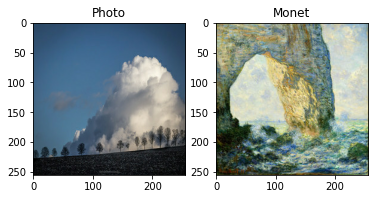

In [9]:
monet_ds_iter = iter(monet_ds)
photo_ds_iter = iter(photo_ds)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# CycleGan Model

#### Generator

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [12]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

#### Discriminator

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

#### Initialize Generators And Discriminators

In [14]:

with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

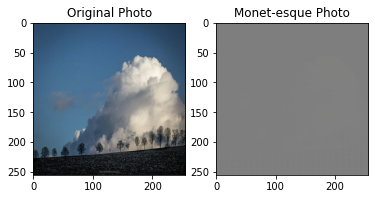

In [15]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

#### Define CycleGan Model

In [16]:
# Generate a CallBack function to save
# the prediction, for each epoch, of the Photo above 
class GANMonitor(keras.callbacks.Callback):
   """A callback to generate and save images after each epoch"""

   def on_epoch_end(self, epoch, logs=None):
       prediction = gen_monet(photo, training=False)[num_photo].numpy()
       prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
       im_to_gif[epoch] = prediction 

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Loss

In [18]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [19]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [20]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [21]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### FID - Frechet Distance

In [22]:
with strategy.scope():

    inception_model = tf.keras.applications.InceptionV3(input_shape=(256,256,3),pooling="avg",include_top=False)

    mix3  = inception_model.get_layer("mixed9").output
    f0 = tf.keras.layers.GlobalAveragePooling2D()(mix3)

    inception_model = tf.keras.Model(inputs=inception_model.input, outputs=f0)
    inception_model.trainable = False

    def calculate_activation_statistics_mod(images,fid_model):

            act=tf.cast(fid_model.predict(images), tf.float32)

            mu = tf.reduce_mean(act, axis=0)
            mean_x = tf.reduce_mean(act, axis=0, keepdims=True)
            mx = tf.matmul(tf.transpose(mean_x), mean_x)
            vx = tf.matmul(tf.transpose(act), act)/tf.cast(tf.shape(act)[0], tf.float32)
            sigma = vx - mx
            return mu, sigma
    myFID_mu2, myFID_sigma2 = calculate_activation_statistics_mod(fid_monet_ds,inception_model)        
    fids=[]

87916544/87910968 [==============================] - 1s 0us/step


In [23]:
with strategy.scope():
    def calculate_frechet_distance(mu1,sigma1,mu2,sigma2):
        fid_epsilon = 1e-14
       
        covmean = tf.linalg.sqrtm(tf.cast(tf.matmul(sigma1,sigma2),tf.complex64))
#         isgood=tf.cast(tf.math.is_finite(covmean), tf.int32)
#         if tf.size(isgood)!=tf.math.reduce_sum(isgood):
#             return 0

        covmean = tf.cast(tf.math.real(covmean),tf.float32)
        tr_covmean = tf.linalg.trace(covmean)

        return tf.matmul(tf.expand_dims(mu1 - mu2, axis=0),tf.expand_dims(mu1 - mu2, axis=1)) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean

    def FID(images,gen_model,inception_model=inception_model,myFID_mu2=myFID_mu2, myFID_sigma2=myFID_sigma2):
                inp = layers.Input(shape=[256, 256, 3], name='input_image')
                x  = gen_model(inp)
                x=inception_model(x)
                fid_model = tf.keras.Model(inputs=inp, outputs=x)
                mu1, sigma1= calculate_activation_statistics_mod(images,fid_model)
                fid_value = calculate_frechet_distance(mu1, sigma1,myFID_mu2, myFID_sigma2)
                return fid_value

#### Optimizerrs

In [24]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Steps 1,2 - Base Line Model Evaluation



In [25]:
def evaluate_model(epochs, data, fid_flag):
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos
    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

    # define model
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    # compile model
    cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss)

    plotter = GANMonitor()

    hist = cycle_gan_model.fit(data, epochs=epochs, callbacks=[History()])


    if (fid_flag):
      fids=[]
      best_fid=999999999
      for epoch in range(1,epochs):
          print("Epoch = ",epoch)
          cycle_gan_model.fit(data, epochs=epochs, callbacks=[History()])
          # if epoch>35:
          cur_fid=FID(fid_photo_ds,monet_generator_30)
          fids.append(cur_fid)
          print("After epoch #{} FID = {}\n".format(epoch,cur_fid))
          # if epoch>42:
          #      best_fid=cur_fid
          #      monet_generator.save('monet_generator_'+str(epoch)+'.h5')
      plt.plot(np.array(fids).reshape(-1,), label='FID')
      plt.legend()
      plt.show()

    return hist

#### BaseLineModel - 300 Monets

In [26]:
%%script false 

%%time
with strategy.scope():
    data_set = tf.data.Dataset.zip((monet_ds, photo_ds))
    history = evaluate_model(EPOCHS, data_set, False)

In [27]:
%%script false 

plot_smoothed_acc_and_loss(EPOCHS, history, 0.8 )

#### BaseLineModel - 30 Monets

In [28]:
%%script false 

%%time

with strategy.scope():
    data_set = tf.data.Dataset.zip((monet_ds.take(30), photo_ds))
    history = evaluate_model(EPOCHS, data_set, False)

In [29]:
%%script false 

plot_smoothed_acc_and_loss(EPOCHS, history, 0.8 )

# Step 2.5 - Choosing The Right 30 Images

#### Grading The Monet Photos With Library Image-Quality

In [30]:
%%script false 


dict = {}
for i, image in enumerate(monet_ds):
    # image = decode_image(image)
    score =  brisque.score(image[0])
    print(i , " scor : " ,score)
    dict[i] = score
print(dict)
sorted(dict.items(), key=lambda item: item[1])
print(dict)
dict_sorted = sorted((value,key) for (key,value) in dict.items())
print()
print(dict_sorted)
print()
#best 100 images:
print()
for i in range (1,100):
    print(dict_sorted[i])

#### Taking The Most 1000 Best Photos

In [31]:
%%script false 

list = []
for i in range(0,30):
    list.append(dict_sorted[i][1])
! mkdir /content/best30
i = 0
for  i, image in enumerate(monet_ds):
    # print(dict_sorted[i][1], i)
    if i in list:
        print("mathc")
        img = image[0].numpy()
        img = (img * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(img)
        im.save("/content/best30/" + str(i) + ".jpg")

    i += 1
shutil.make_archive("/content/bestim", 'zip', "/content/best30")


#### Histograming Colors So We Can Choose 30 out of 100

#### Converting 30 Image Files To Tfrec File

In [32]:
%%script false 


files = get_zip_filenames('/content/bestim.zip')
print (files)

In [33]:
%%script false 



convert_to_tfrec(files, 'monet.tfrec')

#### Prepare The Chosen 30 Data Set (tf.data.dataset format)
whwll we loaded it up first

In [34]:
%%script false 


# COSHEN_MONET_DS_FILENAMES = tf.io.gfile.glob(str('/content/monet.tfrec'))

# chosen_ds = load_dataset(COSHEN_MONET_DS_FILENAMES, labeled=True).batch(1)

# Step 3 -  Augmentation Model Check

#### Quick Snap Of Those 30

In [47]:
display_samples(chosen_ds, 6, 5)

UnimplementedError: ignored

<Figure size 1080x1296 with 0 Axes>

#### Augmentation Definition

In [48]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [49]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  if shuffle:
    ds = ds.shuffle(1000)
  print("after shuffle:")
  print(ds)

  # Batch all datasets
  # ds = ds.batch(batch_size)

  print("after batch:")
  print(ds)

  # Use data augmentation only on the training set
  if augment:
    ds = ds.map(lambda x: (data_augmentation(x, training=True)), 
                num_parallel_calls=AUTOTUNE)
    
  print("after augment:")
  print(ds)
  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

#### Perform Augmentation 10 Times to Increase 30 to 300

In [50]:
print("original:")
print(chosen_ds)

new_chosen_ds_a = prepare(chosen_ds, shuffle=False, augment=True)
display_samples(new_chosen_ds_a, 3, 10)

new_chosen_ds_b = prepare(chosen_ds, shuffle=False, augment=True)
display_samples(new_chosen_ds_b, 3, 10)

new_chosen_ds_c = prepare(chosen_ds, shuffle=False, augment=True)
display_samples(new_chosen_ds_c, 3, 10)

new_chosen_ds_d = prepare(chosen_ds, shuffle=False, augment=True)
display_samples(new_chosen_ds_d, 3, 10)

new_chosen_ds_e = prepare(chosen_ds, shuffle=False, augment=True)
display_samples(new_chosen_ds_e, 3, 10)

new_chosen_ds_f = prepare(chosen_ds, shuffle=False, augment=True)
display_samples(new_chosen_ds_f, 3, 10)

new_chosen_ds_g = prepare(chosen_ds, shuffle=False, augment=True)
display_samples(new_chosen_ds_g, 3, 10)

new_chosen_ds_h = prepare(chosen_ds, shuffle=False, augment=True)
display_samples(new_chosen_ds_h, 3, 10)

new_chosen_ds_i = prepare(chosen_ds, shuffle=False, augment=True)
display_samples(new_chosen_ds_i, 3, 10)




original:
<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>
after shuffle:
<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>
after batch:
<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>
after augment:
<ParallelMapDataset shapes: (None, 256, 256, 3), types: tf.float32>


UnimplementedError: ignored

<Figure size 1080x288 with 0 Axes>

#### Combine All New Augmented Data

#### step 3.1 - 300 monets with basic augmentation

In [ ]:
# save all 10 mini datasets to folder

# create zip

# use the code above to create tfrec name: augmented_one

In [ ]:
def save_image_to_folder(image, path, i):
    print("saving image to folder" + path)
    img = image[0].numpy()
    img = (img * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(img)
    im.save(path + str(i) + ".jpg")

def save_bulk_to_folder(ds, path, i):
    j=i
    for  _, image in enumerate(ds):
        save_image_to_folder(image, path, j)
        j += 1
        print(j)
    return j

In [ ]:
! mkdir /content/augmented_one
path = '/content/augmented_one/'
i=0
i = save_bulk_to_folder(new_chosen_ds_a, path, i)
print(i)
i = save_bulk_to_folder(new_chosen_ds_b, path, i)
print(i)
i = save_bulk_to_folder(new_chosen_ds_c, path, i)
i = save_bulk_to_folder(new_chosen_ds_d, path, i)
i = save_bulk_to_folder(new_chosen_ds_e, path, i)
i = save_bulk_to_folder(new_chosen_ds_f, path, i)
i = save_bulk_to_folder(new_chosen_ds_g, path, i)
i = save_bulk_to_folder(new_chosen_ds_h, path, i)
i = save_bulk_to_folder(new_chosen_ds_i, path, i)
i = save_bulk_to_folder(chosen_ds, path, i) # the 30 originals :)

shutil.make_archive("/content/aug_one", 'zip', "/content/augmented_one")


In [ ]:
files = get_zip_filenames('/content/aug_one.zip')
print (files)

In [ ]:
convert_to_tfrec(files, 'augmented_one.tfrec')

In [ ]:
COSHEN_MONET_DS_FILENAMES = tf.io.gfile.glob(str('/content/augmented_one.tfrec'))

chosen_ds_augmented = load_dataset(COSHEN_MONET_DS_FILENAMES, labeled=True).batch(1)

In [ ]:
%%time
with strategy.scope():
    data_set = tf.data.Dataset.zip((chosen_ds_augmented, photo_ds))
    history = evaluate_model(EPOCHS, data_set, False)

In [ ]:
while True: pass

#### step 3.2 Adding Augmentations to some data (variety)

#### Example Of Our Results - save for the last model? or impleent as every one

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Save TensorFlow Model (H5)
The Best Model With The Best Images After it has been trained

In [ ]:
monet_generator.save('/content/monet_generator.h5')
photo_generator.save('/content/photo_generator.h5')
monet_discriminator.save('/content/monet_discriminator.h5')
photo_discriminator.save('/content/photo_discriminator.h5')